In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from GENIE3 import *

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import SAUCIE
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

sys.path.append(os.getcwd())

In [4]:
from consolidated_runs import run_simulations
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
datasets = range(3, 4) # DS3
run_results = run_simulations(datasets,
                              #setting to true will run SERGIO to create clean & noisy data. Must be set to true to run GENIE3 on clean & noisy data
                              sergio=False,
                              saucie=True, 
                              scScope=True, 
                              deepImpute=True, 
                              magic=True, 
                              genie=True,
                              roc=True,
                              precision_recall_k=True
                            )

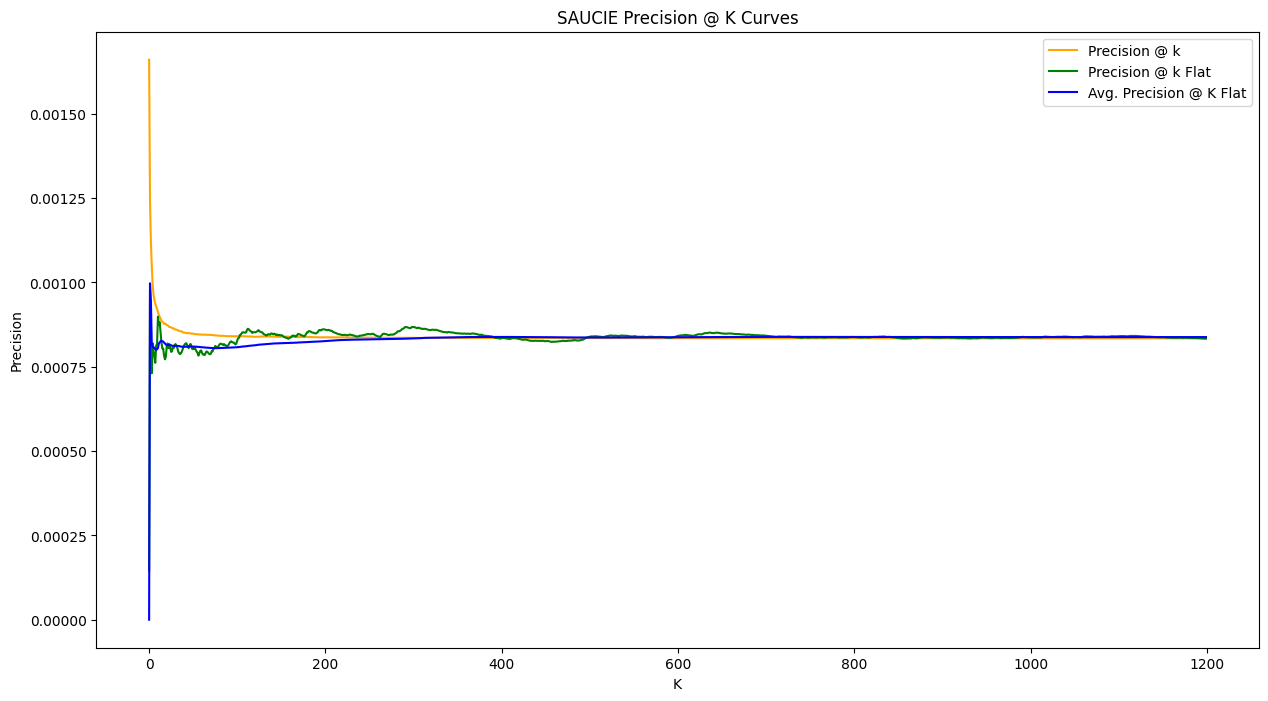

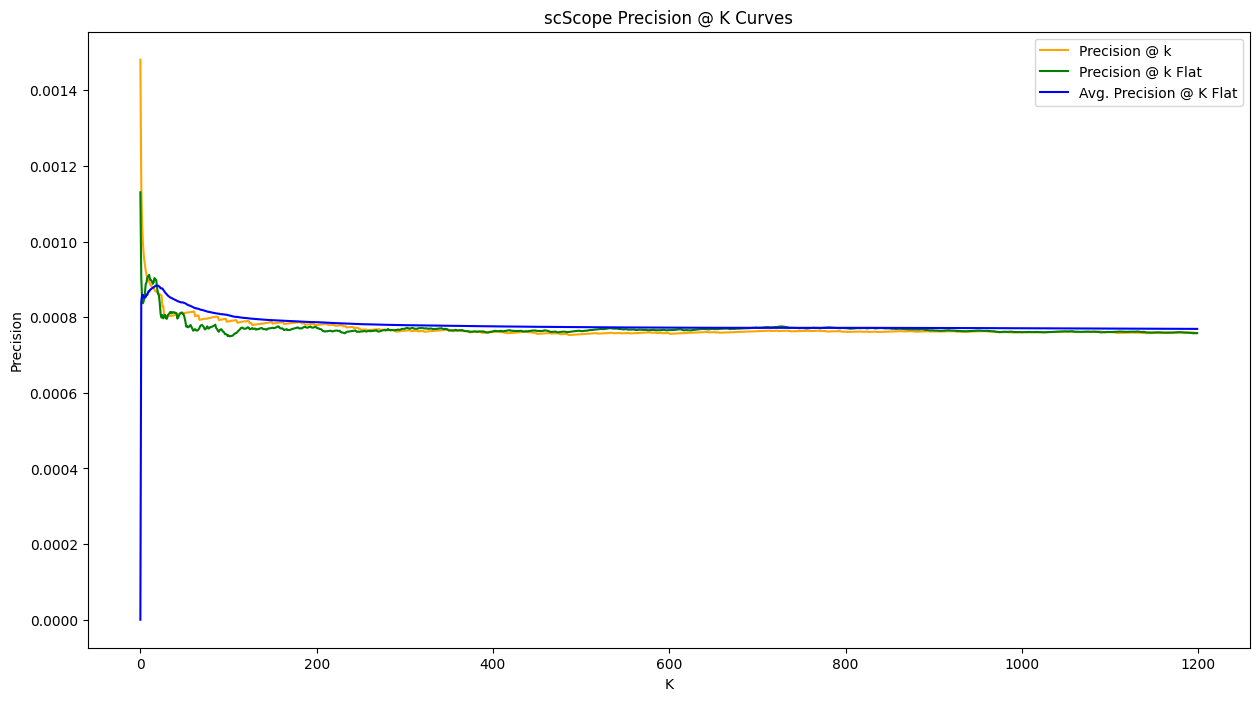

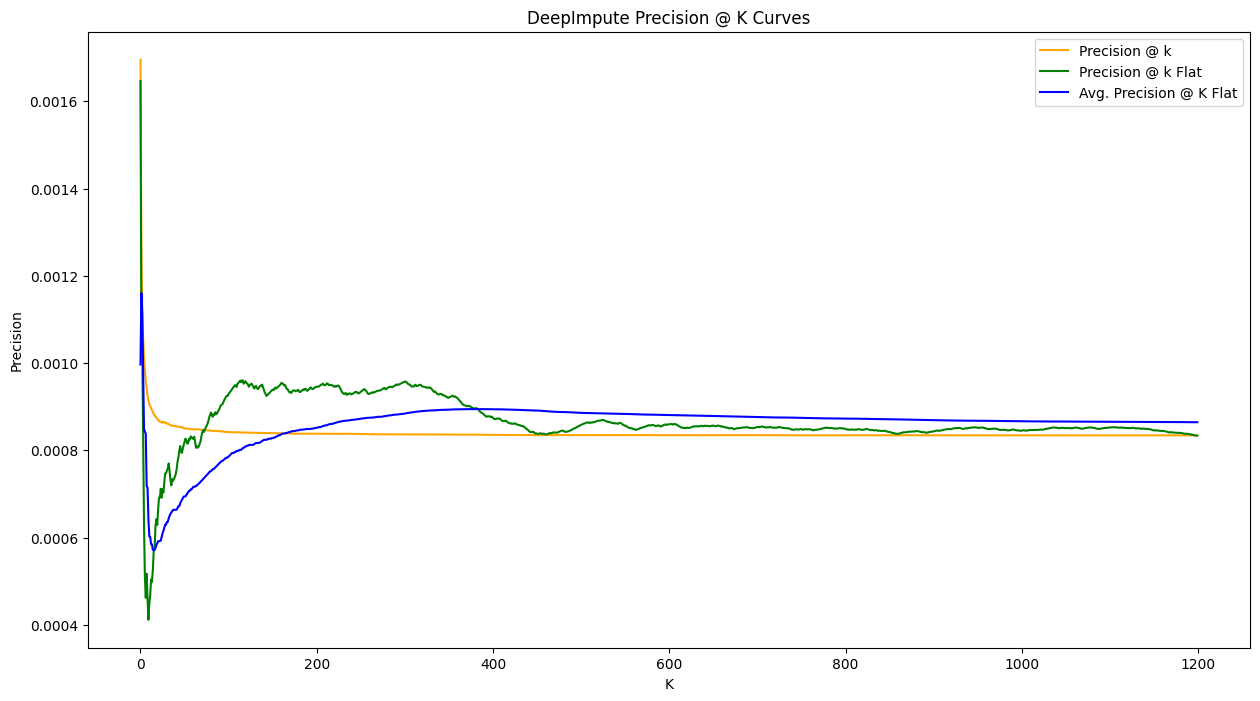

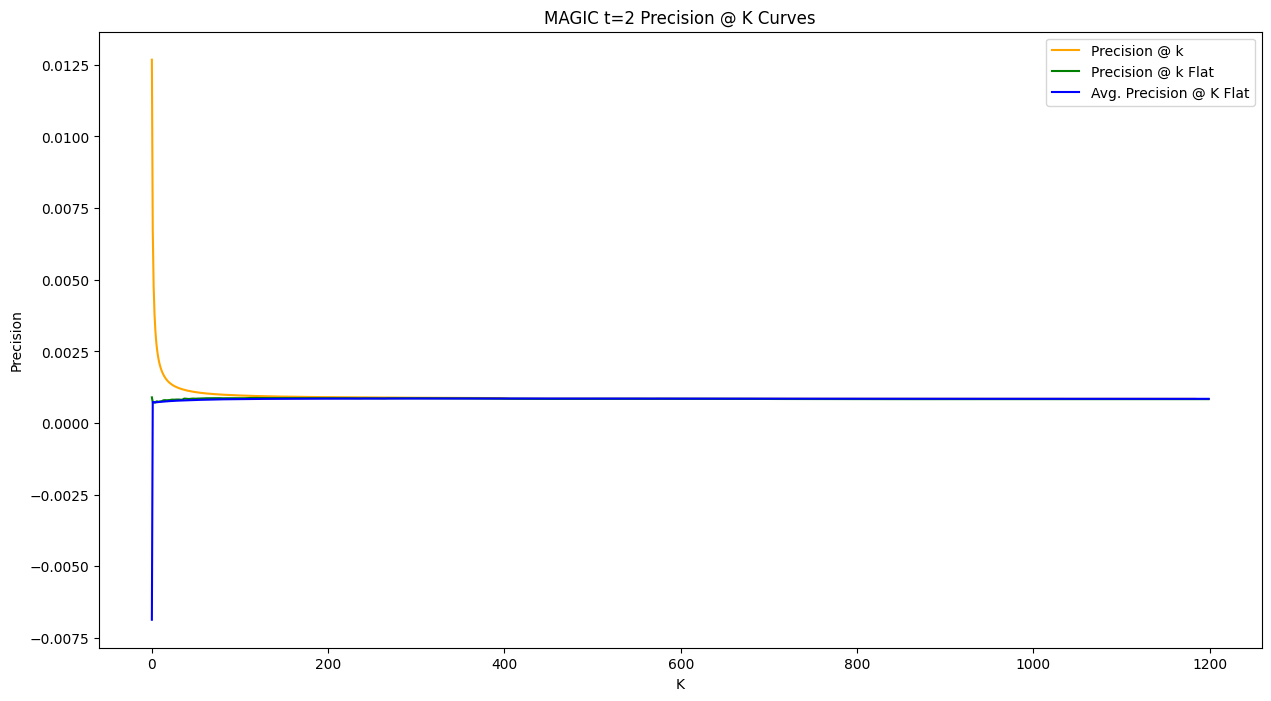

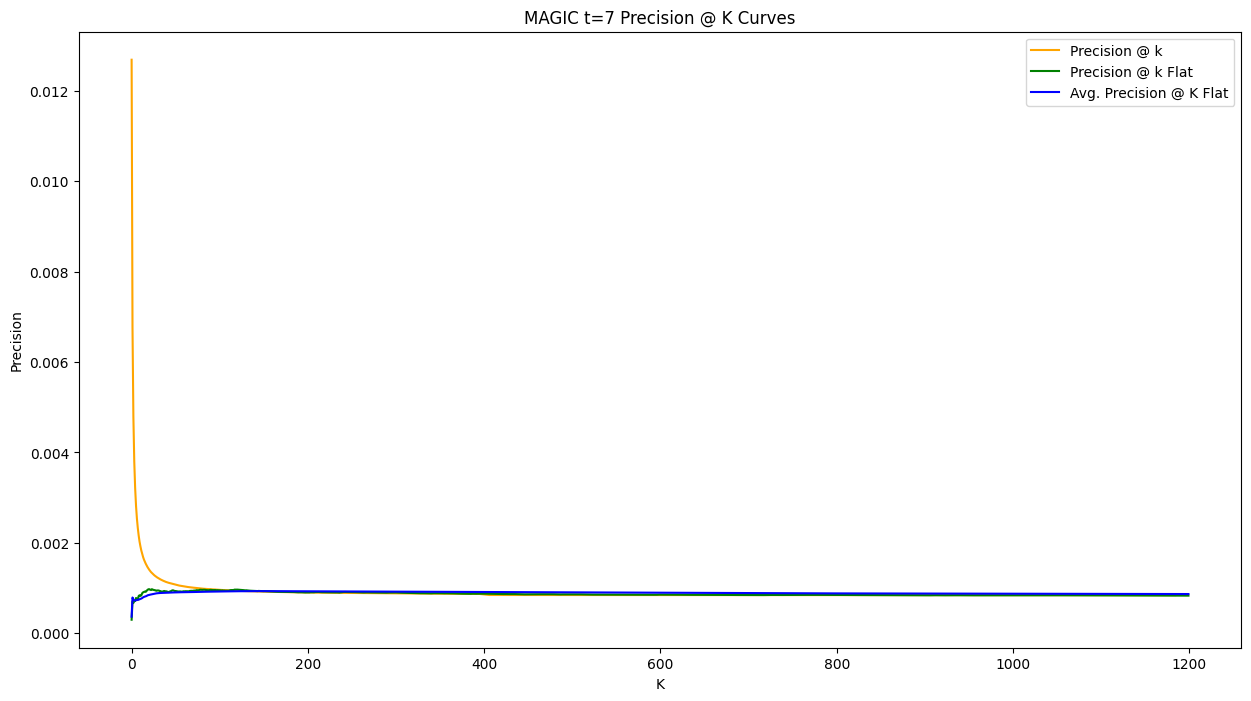

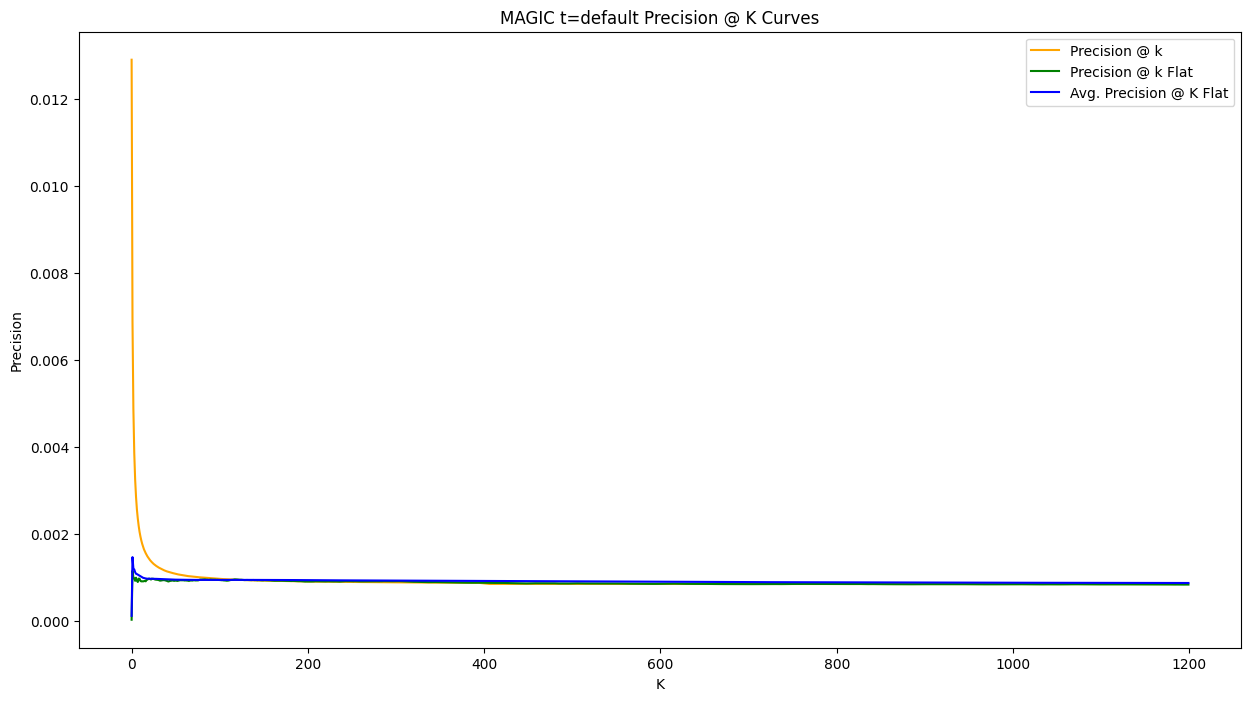

In [19]:
import json
from utils import plot_precisions
methods = ["SAUCIE", "scScope", "DeepImpute", "MAGIC t=2", "MAGIC t=7", "MAGIC t=default"]
strings = [" Precision@k", " Flat Precision@k", " Avg Precision@k"]
results = None
with open('../imputations/DS3/precision_recall_data.json', 'r') as fp:
    results = json.load(fp)

for method in methods:
    pr = results[method + strings[0]]
    flat_pr = results[method + strings[1]]
    avg_pr = results[method + strings[2]]
    plot_precisions(pr, flat_pr, avg_pr, method)

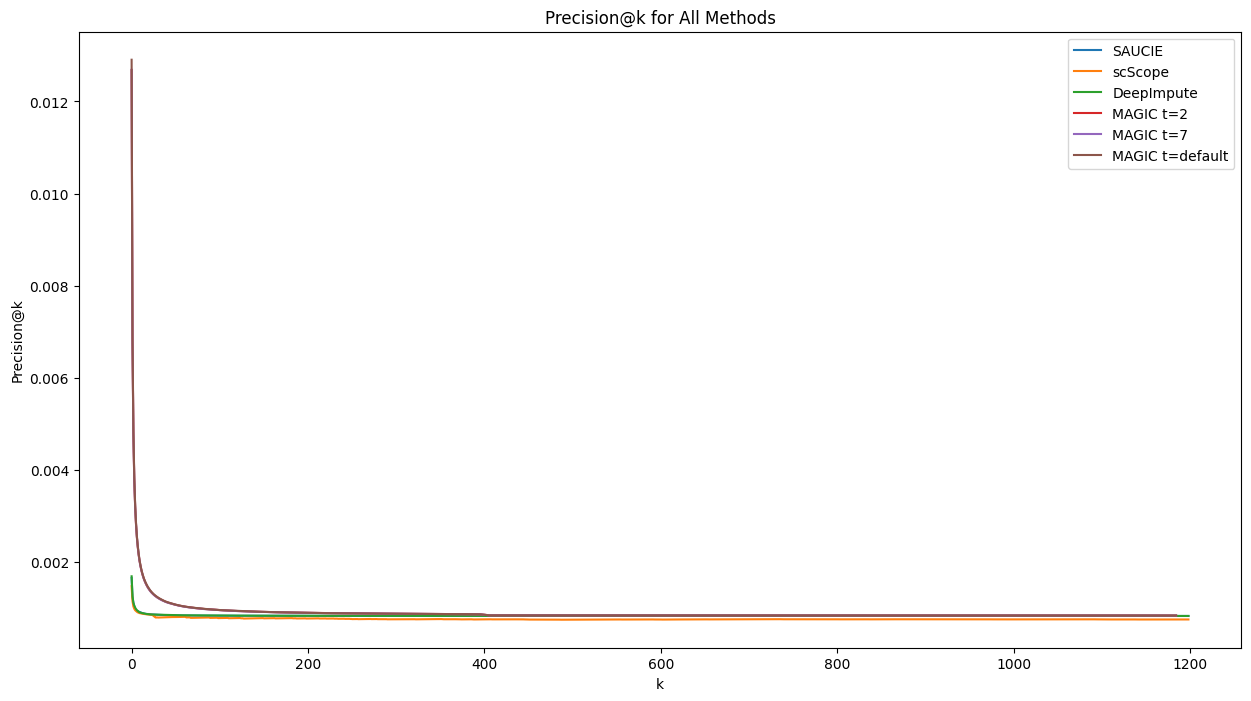

In [21]:
plt.figure(figsize=(15, 8))
for method in methods:
    pr = results[method + strings[0]]
    # flat_pr = results[method + strings[1]]
    # avg_pr = results[method + strings[2]]
    # plot_precisions(pr, flat_pr, avg_pr, method)
    plt.plot(pr, label=method)
plt.xlabel("k")
plt.ylabel("Precision@k")
plt.title("Precision@k for All Methods")
plt.legend()
plt.show()

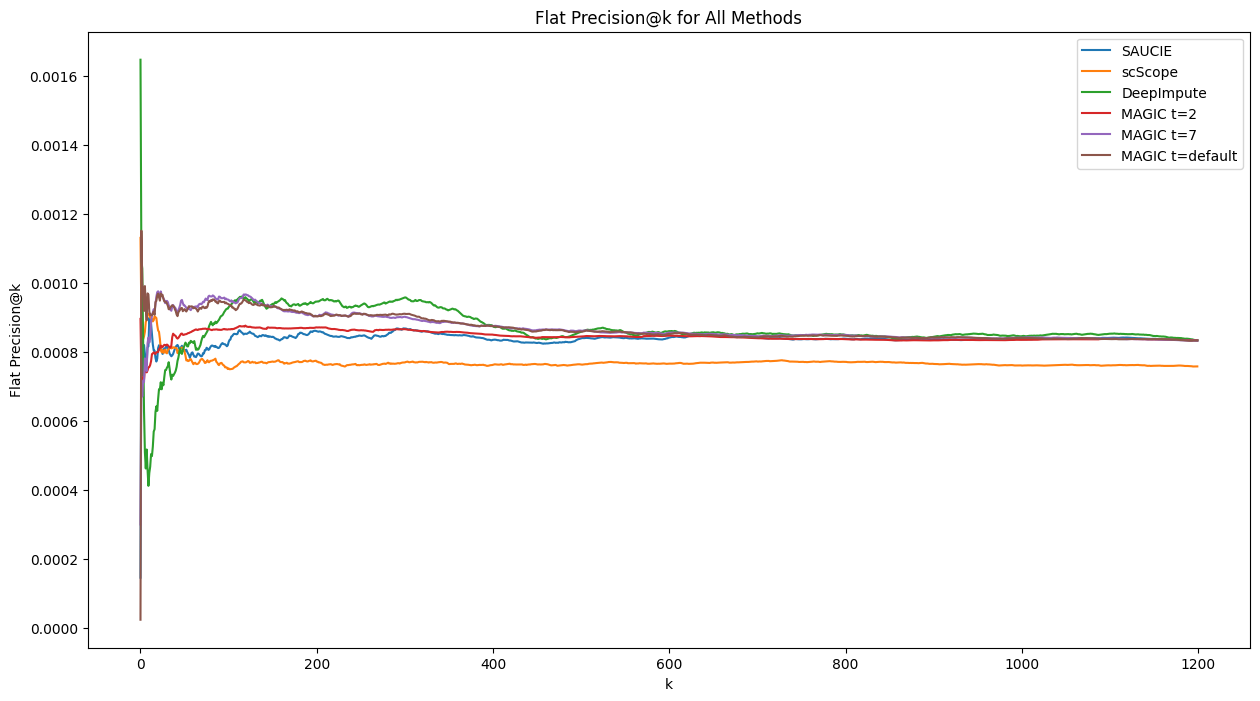

In [22]:
plt.figure(figsize=(15, 8))
for method in methods:
    #pr = results[method + strings[0]]
    flat_pr = results[method + strings[1]]
    # avg_pr = results[method + strings[2]]
    # plot_precisions(pr, flat_pr, avg_pr, method)
    plt.plot(flat_pr, label=method)
plt.xlabel("k")
plt.ylabel("Flat Precision@k")
plt.title("Flat Precision@k for All Methods")
plt.legend()
plt.show()

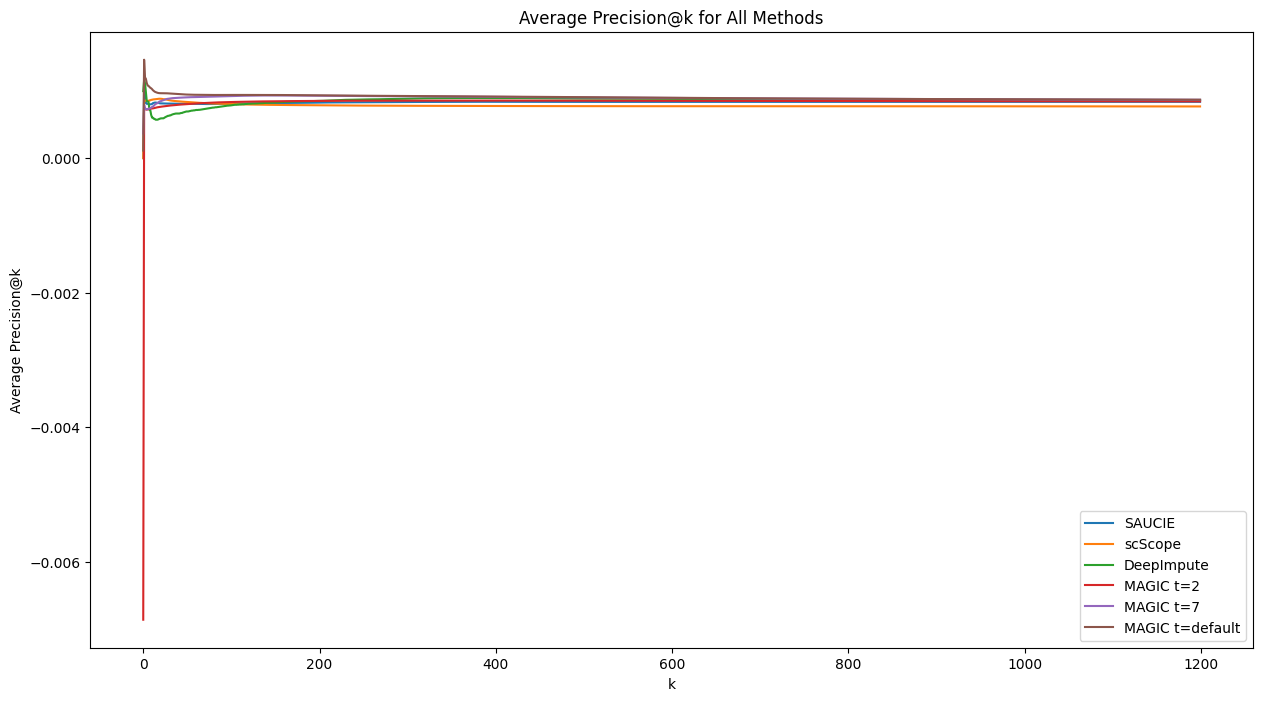

In [28]:
plt.figure(figsize=(15, 8))
for method in methods:
    #pr = results[method + strings[0]]
    #flat_pr = results[method + strings[1]]
    avg_pr = results[method + strings[2]]
    # plot_precisions(pr, flat_pr, avg_pr, method)
    plt.plot(avg_pr, label=method)
plt.xlabel("k")
plt.ylabel("Average Precision@k")
plt.title("Average Precision@k for All Methods")
plt.legend()
plt.show()

In [267]:
def new_recall_k(vim, gt, k_vals, get_locs=False):
    vim_flat = vim.flatten()
    gt_flat = gt.flatten()
    k_averages = []
    for k in tqdm(k_vals):
        recalls = []
        for i, gene in enumerate(vim):
            sorted = gene.argsort()
            top_k = sorted[-k:]
            top_k_gt = gt[i][top_k]
            denom = np.sum(gt[i])
            recall = 0
            if denom != 0:
                recall = np.sum(top_k_gt) / denom                
            recalls.append(recall)
        avg = np.mean(recalls)
        k_averages.append(avg)
    return k_averages

In [245]:
def flat_recall_k(vim, gt, k_vals, get_locs=False):
    vim_flat = vim.flatten()
    gt_flat = gt.flatten()
    sorted = np.argsort(vim_flat)
    recalls = [0] * len(k_vals)
    denom = np.sum(gt_flat)
    gt_sum = 0
    for k in tqdm(k_vals[::-1]):
        top_k = sorted[-k:]
        if k == k_vals[-1]:  
            gt_sum = np.sum(gt_flat[top_k])
        else:
            gt_sum -= gt_flat[top_k[0]]
        recall = 0
        if denom != 0:
            recall = gt_sum / denom  
        recalls[k - 1] = recall
    return recalls

In [ ]:
# k = range(1, gt.size)
# precisions = new_pr_k(vim, gt, range(1, gt.shape[0]))
# flat_precisions, avg_precisions = flat_precision_k(vim, gt, range(1, gt.size))
# recalls = flat_recall_k(vim, gt, k)
# recalls = recalls[::gt.shape[0]]
# flat_precisions = flat_precisions
# avg_precisions = avg_precisions[::gt.shape[0]]

In [ ]:
#plt.plot(pd.DataFrame(recalls), color='orange')

In [3]:
y = np.transpose(np.load('../previous_imputations/DS6_45.npy'))
x = np.transpose(np.load('../previous_imputations/DS6_clean.npy'))

In [4]:
y_curr = np.transpose(np.load('../SERGIO/imputation_data/DS6_45.npy'))
x_curr = np.transpose(np.load('../SERGIO/imputation_data/DS6_clean.npy'))

In [5]:
target_file = '../SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'

In [6]:
def gt_benchmark(virtual_imputation):
    # Create numpy array of same size as imputation_dataset
    gt_temp = np.zeros_like(virtual_imputation)
    f = open(target_file,'r')
    Lines = f.readlines()
    f.close()
    # For each real gene and measured gene expressions, set new array at coordinates to 1
    for j in tqdm(range(len(Lines))):
        line = Lines[j]
        line_list = line.split(',')
        target_index = int(float(line_list[0]))
        num_regs = int(float(line_list[1]))
        # skip if gene is not present in filtered dataset
        if target_index >= gt_temp.shape[1]:
            for i in range(0, target_index + 1 - gt_temp.shape[1]):
                new_column = np.zeros((gt_temp.shape[0], 1), dtype=int)
                gt_temp = np.append(gt_temp, new_column, axis=1)
                virtual_imputation = np.append(virtual_imputation, new_column, axis=1)
        for i in range(num_regs):
            reg_index = int(float(line_list[i+2]))
            gt_temp[reg_index,target_index] = 1  
    return gt_temp, virtual_imputation

In [7]:
# Load SAUCIE imputed data
y_hat_saucie = np.load('../previous_imputations/yhat_saucie.npy')
y_hat_saucie2 = np.load('../SAUCIE/yhat_saucie.npy')

# Load scScope imputed data
y_hat_scscope = np.load('../previous_imputations/yhat_scScope.npy')
y_hat_scscope2 = np.load('../scScope/yhat_scScope.npy')

# Load DeepImpute imputed data
y_hat_deepimp = np.load('../previous_imputations/yhat_deepimp.npy')
y_hat_deepimp2 = np.load('../deepimpute/yhat_deepimp.npy')

# Load MAGIC imputed data
y_hat_magic_t2 = np.load('../MAGIC/yhat_MAGIC_t_2.npy')
y_hat_magic_t7 = np.load('../MAGIC/yhat_MAGIC_t_7.npy')
y_hat_magic_t_auto = np.load('../MAGIC/yhat_MAGIC_t_auto.npy')

In [8]:
print("----------")
print(f"number of zeros in previous clean data: {x.size - np.count_nonzero(x)}")
print(f"number of zeros in previous noisy data: {y.size - np.count_nonzero(y)}")
print(f"number of zeros in current clean data:  {x_curr.size - np.count_nonzero(x_curr)}")
print(f"number of zeros in current noisy data:  {y_curr.size - np.count_nonzero(y_curr)}")
print("----------")
print(f"number of zeros in previous SAUCIE: {y_hat_saucie.size - np.count_nonzero(y_hat_saucie)}")
print(f"number of zeros in current SAUCIE:  {y_hat_saucie2.size - np.count_nonzero(y_hat_saucie2)}")
print("----------")
print(f"number of zeros in previous scscope: {y_hat_scscope.size - np.count_nonzero(y_hat_scscope)}")
print(f"number of zeros in current scscope:  {y_hat_scscope2.size - np.count_nonzero(y_hat_scscope2)}")
print("----------")
print(f"number of zeros in previous deepimpute: {y_hat_deepimp.size - np.count_nonzero(y_hat_deepimp)}")
print(f"number of zeros in current deepimpute:  {y_hat_deepimp2.size - np.count_nonzero(y_hat_deepimp2)}")
print("----------")
print(f"number of zeros in MAGIC t=2:       {y_hat_magic_t2.size - np.count_nonzero(y_hat_magic_t2)}")
print(f"number of zeros in MAGIC t=7:       {y_hat_magic_t7.size - np.count_nonzero(y_hat_magic_t7)}")
print(f"number of zeros in MAGIC t=default: {y_hat_magic_t_auto.size - np.count_nonzero(y_hat_magic_t_auto)}")

----------
number of zeros in previous clean data: 34747
number of zeros in previous noisy data: 3151541
number of zeros in current clean data:  33945
number of zeros in current noisy data:  3185015
----------
number of zeros in previous SAUCIE: 0
number of zeros in current SAUCIE:  1
----------
number of zeros in previous scscope: 452511
number of zeros in current scscope:  333501
----------
number of zeros in previous deepimpute: 1183960
number of zeros in current deepimpute:  1183210
----------
number of zeros in MAGIC t=2:       92512
number of zeros in MAGIC t=7:       0
number of zeros in MAGIC t=default: 0


In [66]:
pd.DataFrame(y_hat_magic_t2).describe(include='all').T['75%'].describe()

count    1195.000000
mean        0.421840
std         2.698270
min         0.010879
25%         0.089034
50%         0.183344
75%         0.342675
max        68.916343
Name: 75%, dtype: float64

In [56]:
pd.DataFrame(y_hat_deepimp).describe(include='all').T['75%'].describe()

count    1200.000000
mean        0.748431
std         1.622393
min         0.000000
25%         0.000000
50%         1.029526
75%         1.080281
max        51.000000
Name: 75%, dtype: float64

In [57]:
pd.DataFrame(y_hat_scscope).describe(include='all').T['75%'].describe()

count    1200.000000
mean        1.005283
std         1.568327
min         0.000000
25%         1.002777
50%         1.065000
75%         1.113207
max        50.969871
Name: 75%, dtype: float64

In [58]:
pd.DataFrame(y).describe(include='all').T['75%'].describe()

count    1200.00000
mean        0.08000
std         1.57024
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max        51.00000
Name: 75%, dtype: float64

In [35]:
y_hat_scscope_imp = y_hat_scscope.copy()
y_hat_scscope_imp[y_hat_scscope_imp == 0] = 1e-5

y_hat_scscope_imp_2 = y_hat_scscope2.copy()
y_hat_scscope_imp_2[y_hat_scscope_imp_2 == 0] = 1e-5

In [59]:
pd.DataFrame(y_hat_scscope_imp).describe(include='all').T['75%'].describe()

count    1200.000000
mean        1.005284
std         1.568326
min         0.000010
25%         1.002777
50%         1.065000
75%         1.113207
max        50.969871
Name: 75%, dtype: float64

In [36]:
print(f"number of zeros in previous scscope: {y_hat_scscope_imp.size - np.count_nonzero(y_hat_scscope_imp)}")
print(f"number of zeros in current scscope:  {y_hat_scscope_imp_2.size - np.count_nonzero(y_hat_scscope_imp_2)}")

number of zeros in previous scscope: 0
number of zeros in current scscope:  0


### Run GENIE3 on SAUCIE Data

Previous Data

In [ ]:
VIM_SAUCIE = GENIE3(y_hat_saucie,nthreads=12,ntrees=100)

In [ ]:
gt, rescaled_vim = gt_benchmark(VIM_SAUCIE)

In [14]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

0.4538860037246973

Current Data

In [ ]:
VIM_SAUCIE = GENIE3(y_hat_saucie2,nthreads=12,ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads


In [ ]:
gt, rescaled_vim = gt_benchmark(VIM_SAUCIE)

In [ ]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

### Run GENIE3 on scScope Data

Previous Data

In [38]:
VIM_scScope = GENIE3(y_hat_scscope_imp,nthreads=12,ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1540.20 seconds


In [39]:
gt, rescaled_vim = gt_benchmark(VIM_scScope)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 610815.74it/s]


In [40]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

0.480381400860843

Current Data

In [41]:
VIM_scScope = GENIE3(y_hat_scscope_imp_2,nthreads=12,ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1705.55 seconds


In [42]:
gt, rescaled_vim = gt_benchmark(VIM_scScope)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 618769.07it/s]


In [43]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

0.4587922618825512

### Run GENIE3 on DeepImpute Data

Previous Data

In [9]:
VIM_DeepImpute = GENIE3(y_hat_deepimp,nthreads=12,ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1554.65 seconds


In [10]:
gt, rescaled_vim = gt_benchmark(VIM_DeepImpute)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 392058.94it/s]


In [11]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

0.32462805057438937

Current Data

In [12]:
VIM_DeepImpute = GENIE3(y_hat_deepimp2,nthreads=12,ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1535.33 seconds


In [13]:
gt, rescaled_vim = gt_benchmark(VIM_DeepImpute)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 529959.45it/s]


In [14]:
roc_auc_score(gt.flatten(),rescaled_vim.flatten())

0.5091760786093034

### Run GENIE3 on MAGIC Data

In [67]:
VIM_MAGIC = GENIE3(y_hat_magic_t2, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1418.71 seconds


In [68]:
gt, rescaled_vim = gt_benchmark(VIM_MAGIC)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 63455.87it/s]


In [69]:
roc_auc_score(gt.flatten(), rescaled_vim.flatten())

0.523414706575866

In [96]:
VIM_MAGIC = GENIE3(y_hat_magic_t7, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 990.08 seconds


In [97]:
gt, rescaled_vim = gt_benchmark(VIM_MAGIC)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 114528.87it/s]


In [98]:
roc_auc_score(gt.flatten(), rescaled_vim.flatten())

0.4972348080309966

In [47]:
VIM_MAGIC = GENIE3(y_hat_magic_t_auto, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1434.76 seconds


In [48]:
gt, rescaled_vim = gt_benchmark(VIM_MAGIC)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 41840.75it/s]


In [49]:
roc_auc_score(gt.flatten(), rescaled_vim.flatten())

0.5004544913467466

### Benchmark: GENIE3 on Clean Data

Previous Data

In [106]:
x = np.transpose(np.load('../previous_imputations/DS6_clean.npy'))

In [107]:
VIM_CLEAN = GENIE3(x, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1067.19 seconds


In [108]:
gt, rescaled_vim = gt_benchmark(VIM_CLEAN)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 694250.76it/s]


In [109]:
roc_auc_score(gt.flatten(), VIM_CLEAN.flatten())

0.8037288061568897

Current Data

In [110]:
x_curr = np.transpose(np.load('../SERGIO/imputation_data/DS6_clean.npy'))

In [111]:
VIM_CLEAN = GENIE3(x_curr, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 1045.56 seconds


In [112]:
gt, rescaled_vim = gt_benchmark(VIM_CLEAN)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 755388.08it/s]


In [113]:
roc_auc_score(gt.flatten(), VIM_CLEAN.flatten())

0.8132766785059842

### Benchmark: GENIE3 on Noisy Data

Previous Data

In [114]:
y = np.transpose(np.load('../previous_imputations/DS6_45.npy'))

In [115]:
VIM_NOISY = GENIE3(y, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 84.61 seconds


In [116]:
gt, rescaled_vim = gt_benchmark(VIM_NOISY)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 484221.16it/s]


In [117]:
roc_auc_score(gt.flatten(), VIM_NOISY.flatten())

0.42851735929047474

Current Data

In [118]:
y_curr = np.transpose(np.load('../SERGIO/imputation_data/DS6_45.npy'))

In [119]:
VIM_NOISY = GENIE3(y_curr, nthreads=12, ntrees=100)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 89.39 seconds


In [120]:
gt, rescaled_vim = gt_benchmark(VIM_NOISY)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:00<00:00, 701527.37it/s]


In [122]:
roc_auc_score(gt.flatten(), VIM_NOISY.flatten())

0.4402483058634301

### Testing on all files

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sys import modules
#print(sys.getrefcount(tf))
modname = 'deepimpute'
count = 0
for key, mod in modules.copy().items():
    try:
        try:
            if modname in str(mod):
                print("val", key, mod)
                count += 1
            # if key.index(modname) != -1:
            #     print("key", key, modname)
            #     count += 1
        except:
            pass            
    except AttributeError:
        pass
print(count)

val deepimpute <module 'deepimpute' from '/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/deepimpute/deepimpute/__init__.py'>
1


In [15]:
l = []
for key in run_results.keys():
    series = run_results[key]
    s_temp = pd.json_normalize(series)
    s_temp['Dataset'] = key
    l.append(s_temp)
temp_df = pd.concat(l).reset_index(drop=True).set_index("Dataset")

In [16]:
temp_df

,SAUCIE
Dataset,
DS3,0.49


In [67]:
temp_df.to_csv('genie3_results_multiple_datasets.csv')

### Create Correlation Plots to Mirror Supplemental Figure 4

In [27]:
from consolidated_runs import create_correlation_plots
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|                                                                                                                        | 0/3 [00:00<?, ?it/s]

---> Calculating correlations for data from DS1


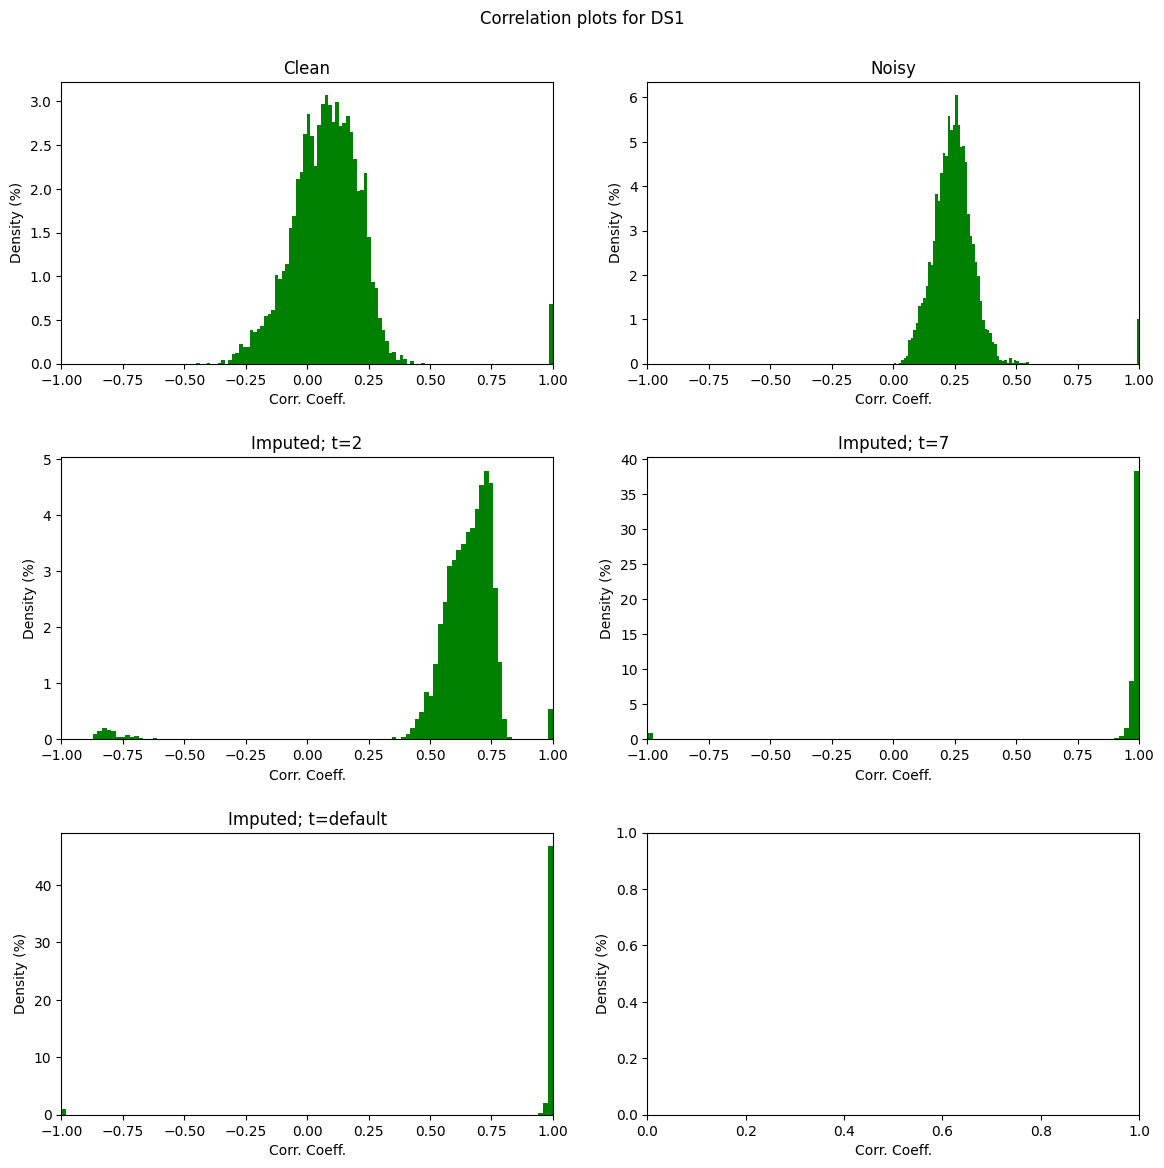

 33%|█████████████████████████████████████▎                                                                          | 1/3 [00:00<00:01,  1.09it/s]

---> Calculating correlations for data from DS2


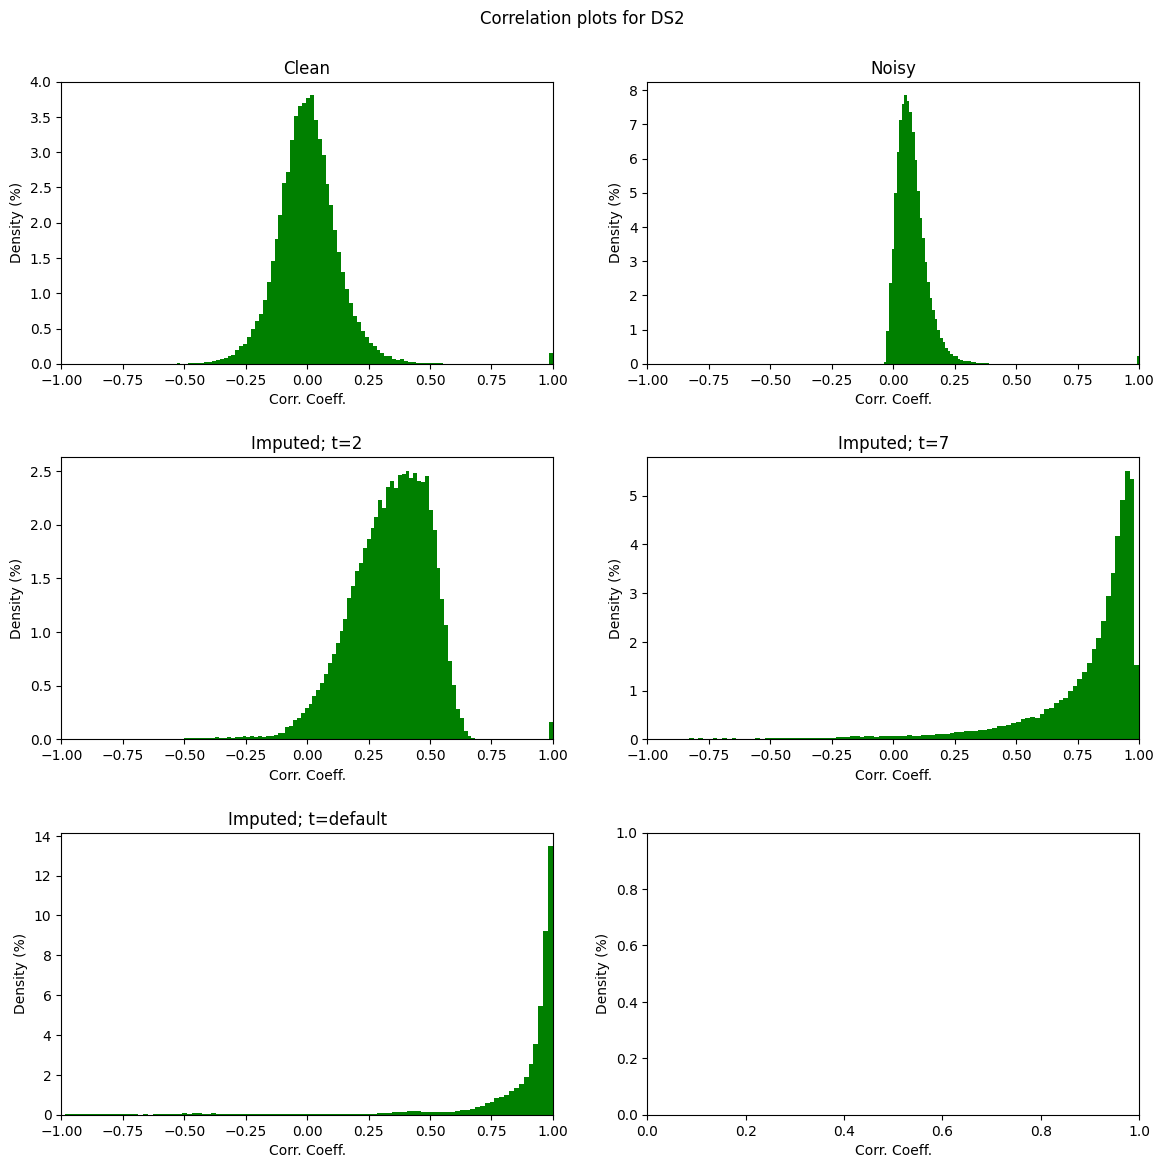

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 2/3 [00:07<00:04,  4.20s/it]

---> Calculating correlations for data from DS3


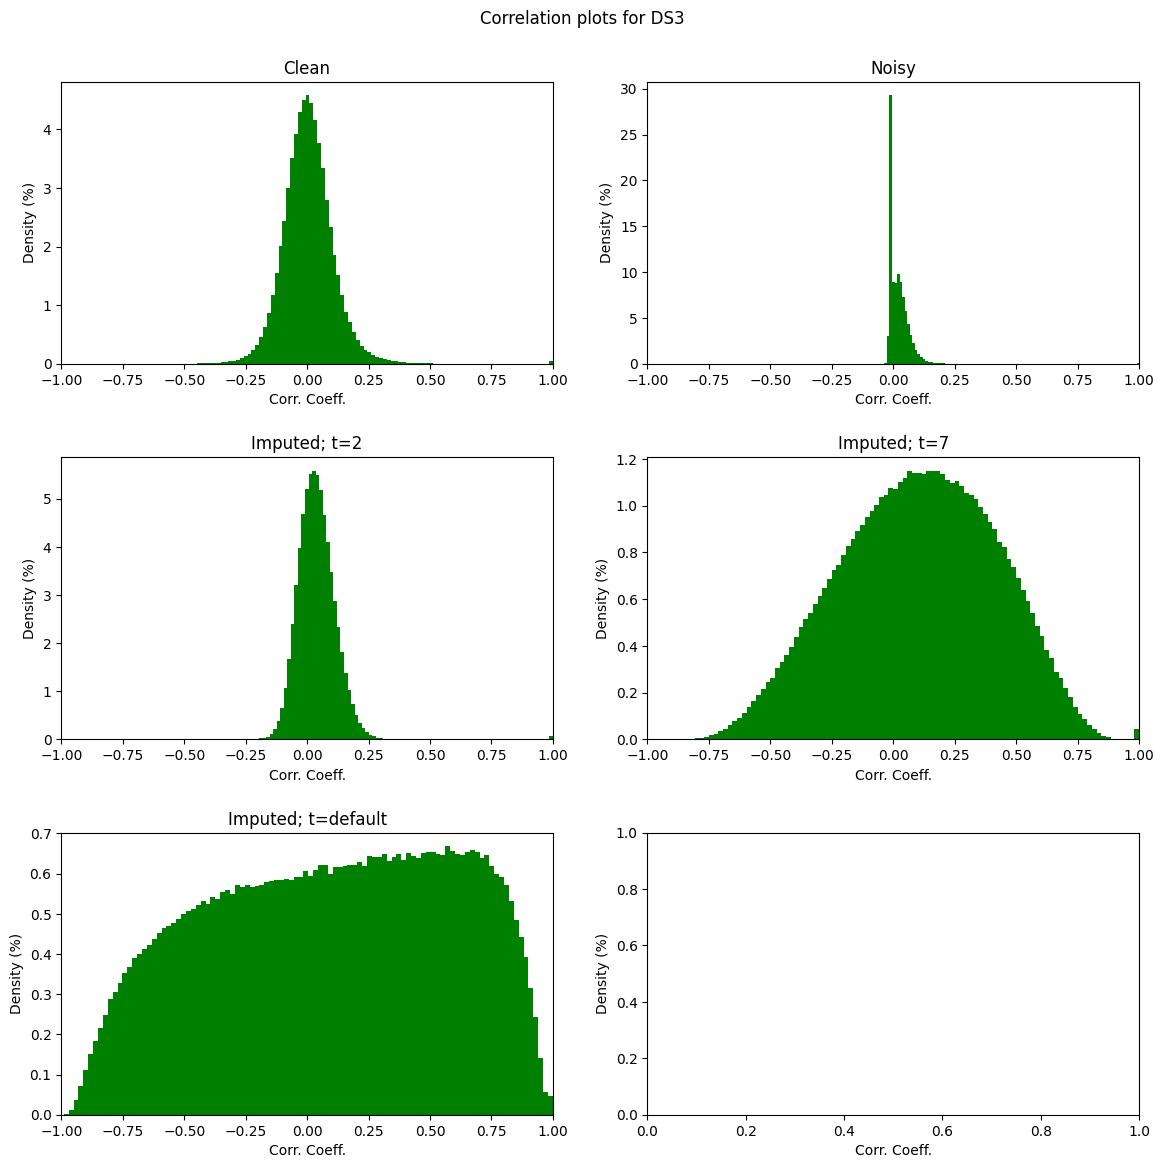

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.56s/it]


In [28]:
datasets = range(1, 4)
#datasets = [1]
run_results = create_correlation_plots(datasets)